In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
import datetime
import time

%load_ext nb_black
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import numpy as np
from sklearn.metrics import (
    recall_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from catboost import CatBoostClassifier

from catboost import Pool

%matplotlib inline

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from skmultilearn.model_selection import (
    iterative_train_test_split,
    IterativeStratification,
)

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    LinearRegression,
    Lasso,
)

from sklearn.svm import SVC, LinearSVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score
from tqdm import tqdm
from catboost import CatBoostClassifier
import warnings

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [47]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_workingday = pd.read_csv("data/WorkingDay.csv", decimal=",")
df_calls = pd.read_csv("data/Calls.csv", decimal=",")
df_connection_time = pd.read_csv(
    "data/ConnectionTime.csv", low_memory=False, decimal=","
)
df_education = pd.read_csv("data/Education.csv", decimal=",")
df_skud = pd.read_csv("data/SKUD.csv", decimal=",")
df_tasks = pd.read_csv("data/Tasks.csv", low_memory=False, decimal=",")
df_network = pd.read_csv("data/TimenNetwork.csv", decimal=",")

<IPython.core.display.Javascript object>

In [48]:
train_users = set(df_train.id.unique().tolist())
test_users = set(df_test.id.unique().tolist())
train_total = len(train_users)
test_total = len(test_users)
df_dict = {
    'df_workingday': df_workingday,
    'df_calls': df_calls,
    'df_connection_time': df_connection_time,
    'df_education': df_education,
    'df_skud': df_skud,
    'df_tasks': df_tasks,
    'df_network': df_network
}


<IPython.core.display.Javascript object>

In [49]:
for key, value in df_dict.items():
    df = value.copy()
    temp_users = set(df.id.unique().tolist())
    interception_train = temp_users.intersection(train_users)
    interception_test = temp_users.intersection(test_users)
    print(f"{key}")
    print(f"Train: {round((len(interception_train) / train_total *100),2)}%")
    print(f"Test: {round((len(interception_test) / test_total *100),2)}%")
    print("")
    print("")

df_workingday
Train: 87.27%
Test: 88.93%


df_calls
Train: 59.64%
Test: 58.4%


df_connection_time
Train: 89.27%
Test: 87.79%


df_education
Train: 87.09%
Test: 85.5%


df_skud
Train: 40.18%
Test: 31.68%


df_tasks
Train: 74.18%
Test: 70.99%


df_network
Train: 87.27%
Test: 88.55%




<IPython.core.display.Javascript object>

In [50]:
def process_workingday(input_df):
    df = input_df.copy()
    df["Вых/Будни"] = df["Вых/Будни"].replace({"Будни": 0, "Выходные дни": 1})
    df = df.rename(columns={"Вых/Будни": "is_weekend"})
    df = df.groupby(["id", "startTime"], as_index=False).agg(
        {"is_weekend": "max", "activeTime": "sum", "monitorTime": "sum"}
    )
    return df

<IPython.core.display.Javascript object>

In [51]:
def process_network(input_df):
    df = input_df.copy()
    df["Вых/Будни"] = df["Вых/Будни"].replace({"Будни": 0, "Выходные дни": 1})
    df = df.rename(columns={"Вых/Будни": "is_weekend_drop"})
    df = df.groupby(["id", "startTime"], as_index=False).agg(
        {"is_weekend_drop": "max", "monitor_Time": "sum"}
    )
    return df

<IPython.core.display.Javascript object>

In [52]:
def process_connection_time(input_df):
    df = input_df.copy()
    df["Вых/Будни"] = df["Вых/Будни"].replace({"Будни": 0, "Выходные дни": 1})
    df["Признак опоздания"] = df["Признак опоздания"].replace({"Опоздание": 1})
    df = df.rename(
        columns={
            "dateNum": "startTime",
            "Вых/Будни": "is_weekend_drop",
            "Признак опоздания": "is_late",
            "Время опоздания": "late_time",
            "Нормативное время начала раб.дня": "norm_start",
            "Фактич. время начала раб.дня": "fact_start",
        }
    )
    df = df.fillna(0)
    dates = ["maxLogOff", "fact_start", "norm_start"]
    for date in dates:
        df[date] = pd.to_datetime(df[date], format="%Y-%m-%d %H:%M:%S,%f")
        df[date] = pd.to_timedelta(df[date].dt.time.astype(str)).dt.total_seconds()
    df["late_time"] = df["late_time"] * 3600

    df = df.groupby(["id", "startTime"], as_index=False).agg(
        {
            "is_weekend_drop": "max",
            "maxLogOff": "max",
            "norm_start": "min",
            "fact_start": "min",
            "late_time": "min",
            "is_late": "min",
        }
    )

    return df

<IPython.core.display.Javascript object>

In [53]:
df_workingday = process_workingday(df_workingday)
df_workingday

,id,startTime,is_weekend,activeTime,monitorTime
0,ОРГ1-00004,"2021-06-21 00:00:00,000",0,22859,51487
1,ОРГ1-00004,"2021-06-22 00:00:00,000",0,15461,84485
2,ОРГ1-00004,"2021-06-23 00:00:00,000",0,23349,90135
3,ОРГ1-00004,"2021-06-24 00:00:00,000",0,13019,85376
4,ОРГ1-00004,"2021-06-25 00:00:00,000",0,14982,82894
...,...,...,...,...,...
186179,ОРГ2-08387,"2021-12-24 00:00:00,000",0,25632,31646
186180,ОРГ2-08387,"2021-12-25 00:00:00,000",0,23265,33549
186181,ОРГ2-08387,"2021-12-26 00:00:00,000",1,7650,37742
186182,ОРГ2-08387,"2021-12-27 00:00:00,000",0,24212,34053


<IPython.core.display.Javascript object>

In [54]:
df_network = process_network(df_network)
df_network

,id,startTime,is_weekend_drop,monitor_Time
0,ОРГ1-00004,"2021-06-21 00:00:00,000",0,31208
1,ОРГ1-00004,"2021-06-22 00:00:00,000",0,22207
2,ОРГ1-00004,"2021-06-23 00:00:00,000",0,30611
3,ОРГ1-00004,"2021-06-24 00:00:00,000",0,19210
4,ОРГ1-00004,"2021-06-25 00:00:00,000",0,21005
...,...,...,...,...
167288,ОРГ2-08387,"2021-12-24 00:00:00,000",0,30607
167289,ОРГ2-08387,"2021-12-25 00:00:00,000",0,30008
167290,ОРГ2-08387,"2021-12-26 00:00:00,000",1,10205
167291,ОРГ2-08387,"2021-12-27 00:00:00,000",0,31523


<IPython.core.display.Javascript object>

In [55]:
df_full_work = pd.merge(
    left=df_workingday, right=df_network, on=["startTime", "id"], how="outer"
)

<IPython.core.display.Javascript object>

In [56]:
df_full_work["is_weekend"] = df_full_work["is_weekend"].fillna(
    df_full_work["is_weekend_drop"]
)
df_full_work = df_full_work.drop("is_weekend_drop", axis=1)

<IPython.core.display.Javascript object>

In [57]:
df_connection_time = process_connection_time(df_connection_time)
df_connection_time

,id,startTime,is_weekend_drop,maxLogOff,norm_start,fact_start,late_time,is_late
0,ОРГ1-00004,"2021-06-21 00:00:00,000",0,67937.730,30600.0,31560.716,960.717,1.0
1,ОРГ1-00004,"2021-06-22 00:00:00,000",0,66599.000,30600.0,30822.583,222.583,0.0
2,ОРГ1-00004,"2021-06-23 00:00:00,000",0,67987.696,30600.0,31007.690,407.690,0.0
3,ОРГ1-00004,"2021-06-24 00:00:00,000",0,66061.880,30600.0,30590.333,0.000,0.0
4,ОРГ1-00004,"2021-06-25 00:00:00,000",0,64323.556,30600.0,30465.113,0.000,0.0
...,...,...,...,...,...,...,...,...
178297,ОРГ2-08204,"2021-12-30 00:00:00,000",0,53072.126,30600.0,29016.683,0.000,0.0
178298,ОРГ2-08215,"2021-12-27 00:00:00,000",0,63102.000,30600.0,42262.100,11662.100,1.0
178299,ОРГ2-08215,"2021-12-28 00:00:00,000",0,64211.496,30600.0,32054.273,1454.273,1.0
178300,ОРГ2-08215,"2021-12-29 00:00:00,000",0,62919.090,30600.0,30191.763,0.000,0.0


<IPython.core.display.Javascript object>

In [58]:
df_full_work = df_full_work.merge(
    df_connection_time, on=["startTime", "id"], how="outer"
)

<IPython.core.display.Javascript object>

In [59]:
df_full_work["is_weekend"] = df_full_work["is_weekend"].fillna(
    df_full_work["is_weekend_drop"]
)
df_full_work = df_full_work.drop("is_weekend_drop", axis=1)

<IPython.core.display.Javascript object>

In [60]:
df_full_work

,id,startTime,is_weekend,activeTime,monitorTime,monitor_Time,maxLogOff,norm_start,fact_start,late_time,is_late
0,ОРГ1-00004,"2021-06-21 00:00:00,000",0.0,22859.0,51487.0,31208.0,67937.730,30600.0,31560.716,960.717,1.0
1,ОРГ1-00004,"2021-06-22 00:00:00,000",0.0,15461.0,84485.0,22207.0,66599.000,30600.0,30822.583,222.583,0.0
2,ОРГ1-00004,"2021-06-23 00:00:00,000",0.0,23349.0,90135.0,30611.0,67987.696,30600.0,31007.690,407.690,0.0
3,ОРГ1-00004,"2021-06-24 00:00:00,000",0.0,13019.0,85376.0,19210.0,66061.880,30600.0,30590.333,0.000,0.0
4,ОРГ1-00004,"2021-06-25 00:00:00,000",0.0,14982.0,82894.0,21005.0,64323.556,30600.0,30465.113,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
208798,ОРГ2-08204,"2021-12-30 00:00:00,000",0.0,NaN,NaN,NaN,53072.126,30600.0,29016.683,0.000,0.0
208799,ОРГ2-08215,"2021-12-27 00:00:00,000",0.0,NaN,NaN,NaN,63102.000,30600.0,42262.100,11662.100,1.0
208800,ОРГ2-08215,"2021-12-28 00:00:00,000",0.0,NaN,NaN,NaN,64211.496,30600.0,32054.273,1454.273,1.0
208801,ОРГ2-08215,"2021-12-29 00:00:00,000",0.0,NaN,NaN,NaN,62919.090,30600.0,30191.763,0.000,0.0


<IPython.core.display.Javascript object>

In [61]:
df_full_work.isna().sum()

id                  0
startTime           0
is_weekend          0
activeTime      22619
monitorTime     22619
monitor_Time    41510
maxLogOff       30501
norm_start      30501
fact_start      30501
late_time       30501
is_late         30501
dtype: int64

<IPython.core.display.Javascript object>

In [62]:
missing_columns = [
    "activeTime",
    "monitorTime",
    "monitor_Time",
    "maxLogOff",
    "norm_start",
    "fact_start",
    "late_time",
    "is_late",
]
df = df_full_work.drop(["id", "startTime"], axis=1).copy()

<IPython.core.display.Javascript object>

In [63]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + "_imp"] = np.random.choice(
        observed_values, number_missing, replace=True
    )

    return df

<IPython.core.display.Javascript object>

In [64]:
for feature in missing_columns:
    df[feature + "_imp"] = df[feature]
    df = random_imputation(df, feature)

<IPython.core.display.Javascript object>

In [65]:
deter_data = pd.DataFrame(columns=["Det_" + name for name in missing_columns])

for feature in missing_columns:

    deter_data["Det_" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + "_imp"})

    # Create a Linear Regression model to estimate the missing data
    model = Lasso()
    model.fit(X=df[parameters], y=df[feature + "_imp"])

    # observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det_" + feature] = model.predict(
        df[parameters]
    )[df[feature].isnull()]

<IPython.core.display.Javascript object>

In [66]:
df_full_work_processed = pd.concat(
    [df_full_work[["id", "startTime", "is_weekend"]], deter_data], axis=1
)

<IPython.core.display.Javascript object>

In [67]:
df_full_work_processed["startTime"] = pd.to_datetime(
    df_full_work_processed["startTime"]
)

<IPython.core.display.Javascript object>

In [68]:
df_full_work_processed

,id,startTime,is_weekend,Det_activeTime,Det_monitorTime,Det_monitor_Time,Det_maxLogOff,Det_norm_start,Det_fact_start,Det_late_time,Det_is_late
0,ОРГ1-00004,2021-06-21,0.0,22859.000000,51487.000000,31208.000000,67937.730,30600.0,31560.716,960.717,1.0
1,ОРГ1-00004,2021-06-22,0.0,15461.000000,84485.000000,22207.000000,66599.000,30600.0,30822.583,222.583,0.0
2,ОРГ1-00004,2021-06-23,0.0,23349.000000,90135.000000,30611.000000,67987.696,30600.0,31007.690,407.690,0.0
3,ОРГ1-00004,2021-06-24,0.0,13019.000000,85376.000000,19210.000000,66061.880,30600.0,30590.333,0.000,0.0
4,ОРГ1-00004,2021-06-25,0.0,14982.000000,82894.000000,21005.000000,64323.556,30600.0,30465.113,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
208798,ОРГ2-08204,2021-12-30,0.0,20523.278353,45908.751066,21613.945332,53072.126,30600.0,29016.683,0.000,0.0
208799,ОРГ2-08215,2021-12-27,0.0,5041.815456,23225.936450,28736.064671,63102.000,30600.0,42262.100,11662.100,1.0
208800,ОРГ2-08215,2021-12-28,0.0,9194.918375,29867.128267,13083.677789,64211.496,30600.0,32054.273,1454.273,1.0
208801,ОРГ2-08215,2021-12-29,0.0,23222.864949,48592.619455,20611.124017,62919.090,30600.0,30191.763,0.000,0.0


<IPython.core.display.Javascript object>

In [69]:
df = df_full_work_processed.copy()

tsfresh_features = [
    "is_weekend",
    "Det_activeTime",
    "Det_monitorTime",
    "Det_monitor_Time",
    "Det_maxLogOff",
    "Det_norm_start",
    "Det_fact_start",
    "Det_late_time",
]

df_extracted_features = extract_features(
    df[["id"] + tsfresh_features],
    default_fc_parameters=MinimalFCParameters(),
    #default_fc_parameters=EfficientFCParameters(),
    column_id="id",
    disable_progressbar=True,
    n_jobs=0,
)


<IPython.core.display.Javascript object>

In [70]:
df_extracted_features = df_extracted_features.reset_index().rename(
    columns={"index": "id"}
)


<IPython.core.display.Javascript object>

In [71]:
df = df[["id"]].merge(df_extracted_features, on="id", how="left")

<IPython.core.display.Javascript object>

In [72]:
df = df.groupby("id", as_index=False).mean()
df = df.fillna(0)

<IPython.core.display.Javascript object>

In [73]:
full_final = df

<IPython.core.display.Javascript object>

In [74]:
full_final

,id,is_weekend__sum_values,is_weekend__median,is_weekend__mean,is_weekend__length,is_weekend__standard_deviation,is_weekend__variance,is_weekend__root_mean_square,is_weekend__maximum,is_weekend__absolute_maximum,...,Det_late_time__sum_values,Det_late_time__median,Det_late_time__mean,Det_late_time__length,Det_late_time__standard_deviation,Det_late_time__variance,Det_late_time__root_mean_square,Det_late_time__maximum,Det_late_time__absolute_maximum,Det_late_time__minimum
0,ОРГ1-00004,51.0,0.0,0.274194,186.0,0.446107,0.199011,0.523635,1.0,1.0,...,1.065122e+06,1136.421642,5726.464075,186.0,11165.224439,1.246622e+08,12548.092587,52323.877000,52323.877000,0.000000
1,ОРГ1-00028,48.0,0.0,0.262295,183.0,0.439882,0.193496,0.512148,1.0,1.0,...,2.268823e+05,0.000000,1239.793940,183.0,3973.518851,1.578885e+07,4162.444123,31045.670000,31045.670000,-13975.061641
2,ОРГ1-00030,3.0,0.0,0.023622,127.0,0.151869,0.023064,0.153695,1.0,1.0,...,2.078794e+05,0.000000,1636.845394,127.0,7598.670026,5.773979e+07,7772.969125,52579.147000,52579.147000,0.000000
3,ОРГ1-00044,26.0,0.0,0.161491,161.0,0.367983,0.135411,0.401859,1.0,1.0,...,3.960708e+05,0.000000,2460.066860,161.0,6254.422105,3.911780e+07,6720.842568,41942.700000,41942.700000,0.000000
4,ОРГ1-00046,53.0,0.0,0.302857,175.0,0.459494,0.211135,0.550325,1.0,1.0,...,1.282335e+06,604.393000,7327.629470,175.0,13003.002224,1.690781e+08,14925.555952,51478.610000,51478.610000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,ОРГ2-08181,0.0,0.0,0.000000,4.0,0.000000,0.000000,0.000000,0.0,0.0,...,5.947987e+04,14890.893000,14869.968250,4.0,10499.911009,1.102481e+08,18203.408663,29698.087000,29698.087000,0.000000
1751,ОРГ2-08203,0.0,0.0,0.000000,7.0,0.000000,0.000000,0.000000,0.0,0.0,...,4.184383e+04,2901.590000,5977.690571,7.0,8832.418539,7.801162e+07,10665.102053,27508.540000,27508.540000,784.237000
1752,ОРГ2-08204,0.0,0.0,0.000000,6.0,0.000000,0.000000,0.000000,0.0,0.0,...,1.321047e+04,0.000000,2201.745000,6.0,4923.251489,2.423841e+07,5393.151794,13210.470000,13210.470000,0.000000
1753,ОРГ2-08215,0.0,0.0,0.000000,4.0,0.000000,0.000000,0.000000,0.0,0.0,...,1.316772e+04,752.810000,3291.930000,4.0,4867.620322,2.369373e+07,5876.268435,11662.100000,11662.100000,0.000000


<IPython.core.display.Javascript object>

In [75]:
df_education

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,Бакалавр технических наук
4,NaN,ОРГ1-00922,Высшее образование,Машины и аппараты химических производств и пре...
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,Специалист сварочного производства I уровня
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,"Дефектоскопист рентгено-, гаммаграфирования"
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",Управление и информатика в технических системах


<IPython.core.display.Javascript object>

In [76]:
def process_education(input_df):
    df = input_df.copy()
    temp_df = (
        df[["Табельный номер руководителя", "id"]]
        .groupby("Табельный номер руководителя", as_index=False)
        .count()
    )
    temp_df = temp_df.rename(
        columns={"id": "num_employees", "Табельный номер руководителя": "to_drop"}
    )
    df = df.merge(temp_df, left_on="id", right_on="to_drop", how="left")
    df = df.drop("to_drop", axis=1)

    temp_df = temp_df.rename(columns={"num_employees": "num_collegues"})
    df = df.merge(
        temp_df, left_on="Табельный номер руководителя", right_on="to_drop", how="left"
    )
    df = df.drop("to_drop", axis=1)

    df = df.fillna(0)
    dum_cols = ["Вид образования", "Табельный номер руководителя"]
    df = pd.get_dummies(df, columns=dum_cols, prefix=dum_cols, drop_first=True)

    df = df.drop(columns=["Специальность"])
    df = df.fillna(0)
    df = df.groupby("id", as_index=False).max()
    return df

<IPython.core.display.Javascript object>

In [77]:
df_education = process_education(df_education)
df_education

,id,num_employees,num_collegues,Вид образования_Аспирантура,Вид образования_Высшее образование,Вид образования_Высшее образование - бакалавриат,"Вид образования_Высшее образование - специалитет, магистратура",Вид образования_Дополнительное профессиональное образование,Вид образования_Начальное общее образование,Вид образования_Начальное профессиональное образование,...,Табельный номер руководителя_ОРГ2-03119,Табельный номер руководителя_ОРГ2-04299,Табельный номер руководителя_ОРГ2-04561,Табельный номер руководителя_ОРГ2-05237,Табельный номер руководителя_ОРГ2-05294,Табельный номер руководителя_ОРГ2-05327,Табельный номер руководителя_ОРГ2-06006,Табельный номер руководителя_ОРГ2-06329,Табельный номер руководителя_ОРГ2-09100,Табельный номер руководителя_ОРГ2-09266
0,ОРГ1-00001,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ОРГ1-00004,7.0,7.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ОРГ1-00005,11.0,11.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ОРГ1-00010,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ОРГ1-00013,0.0,9.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,ОРГ2-09282,0.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4784,ОРГ2-09283,0.0,25.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4785,ОРГ2-09284,0.0,1797.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4786,ОРГ2-09285,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [78]:
df_tasks

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838


<IPython.core.display.Javascript object>

In [79]:
def process_tasks(input_df):
    df = input_df.copy()

    df = df.fillna(0)
    drop_cols = [
        # "ДлительностьПросрочки",
        "ID задачи",
        # "Статус по просрочке",
        "Дата старта задания",
        "Дата завершения задания плановая",
        "Дата завершения задания фактическая",
        # "Срок плановый",
    ]
    df = df.drop(columns=drop_cols)
    df = df.fillna(0)

    dum_cols = [
        "Вид документа",
        "Состояние задания",
        "Срок плановый",
        "ДлительностьПросрочки",
        "Статус по просрочке",
    ]

    df = pd.get_dummies(df, columns=dum_cols, prefix=dum_cols, drop_first=True)

    df_filtered = df.copy()

    X_list = []
    X = df.groupby(by="id", as_index=False).max()[["id"]].copy()
    df_extracted_features = extract_features(
        df_filtered[["id", "Просрочено, дней"]],
        default_fc_parameters=MinimalFCParameters(),
        column_id="id",
        disable_progressbar=True,
        n_jobs=0,
    )
    df_extracted_features = df_extracted_features.reset_index().rename(
        columns={"index": "id"}
    )
    X = X.merge(df_extracted_features, on="id")
    X_list.append(X)

    df2 = pd.concat(X_list)
    df = df.merge(df2, on="id", how="left")
    df = df.drop(columns=["Просрочено, дней"])
    df = df.groupby("id", as_index=False).mean()

    return df

<IPython.core.display.Javascript object>

In [80]:
df_tasks = process_tasks(df_tasks)
df_tasks

,id,Вид документа_Акт,Вид документа_Внутренний документ,Вид документа_Внутренний документ для БП синхронизация 1С,Вид документа_Входящий,Вид документа_Договор,Вид документа_Дополнительное соглашение,Вид документа_Запрос на внесение изменений,Вид документа_Исходящий,Вид документа_Исходящий РМЗ,...,"Просрочено, дней__sum_values","Просрочено, дней__median","Просрочено, дней__mean","Просрочено, дней__length","Просрочено, дней__standard_deviation","Просрочено, дней__variance","Просрочено, дней__root_mean_square","Просрочено, дней__maximum","Просрочено, дней__absolute_maximum","Просрочено, дней__minimum"
0,ОРГ1-00004,0.004363,0.158813,0.033159,0.117801,0.115183,0.174520,0.000000,0.004363,0.0,...,8857.0,0.0,7.728621,1146.0,49.692638,2469.358291,50.290057,495.0,495.0,0.0
1,ОРГ1-00005,0.000451,0.033799,0.000000,0.033799,0.196485,0.451104,0.028391,0.044164,0.0,...,1481.0,0.0,0.667418,2219.0,7.241179,52.434680,7.271872,198.0,198.0,0.0
2,ОРГ1-00028,0.000000,0.745902,0.155738,0.028689,0.000000,0.000000,0.000000,0.000000,0.0,...,51.0,0.0,0.209016,244.0,1.324950,1.755492,1.341335,12.0,12.0,0.0
3,ОРГ1-00030,0.250000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,...,17.0,0.0,0.472222,36.0,1.863183,3.471451,1.922094,11.0,11.0,0.0
4,ОРГ1-00044,0.000000,0.009554,0.000000,0.254777,0.000000,0.000000,0.000000,0.121019,0.0,...,1748.0,0.0,5.566879,314.0,19.937090,397.487565,20.699703,202.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,ОРГ2-06006,0.000000,0.002532,0.000000,0.146835,0.000000,0.000000,0.000000,0.088608,0.0,...,308.0,0.0,0.779747,395.0,5.122262,26.237564,5.181271,91.0,91.0,0.0
1268,ОРГ2-06061,0.000000,0.000000,0.000000,0.175926,0.000000,0.000000,0.000000,0.009259,0.0,...,79.0,0.0,0.731481,108.0,1.818661,3.307527,1.960253,11.0,11.0,0.0
1269,ОРГ2-06084,0.000000,0.000000,0.000000,0.071429,0.142857,0.000000,0.000000,0.214286,0.0,...,140.0,0.0,5.000000,28.0,15.019036,225.571429,15.829448,78.0,78.0,0.0
1270,ОРГ2-06115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,416.0,0.0,69.333333,6.0,155.034046,24035.555556,169.831289,416.0,416.0,0.0


<IPython.core.display.Javascript object>

In [81]:
df_list = [
    # df_calls,
    full_final,
    df_education,
    # df_skud,
    df_tasks,
]
for df in df_list:
    new_df = df.copy()
    df_train = df_train.merge(new_df, on="id", how="left")
    df_test = df_test.merge(new_df, on="id", how="left")

<IPython.core.display.Javascript object>

In [82]:
df_train.columns.tolist()

['id',
 'type',
 'is_weekend__sum_values',
 'is_weekend__median',
 'is_weekend__mean',
 'is_weekend__length',
 'is_weekend__standard_deviation',
 'is_weekend__variance',
 'is_weekend__root_mean_square',
 'is_weekend__maximum',
 'is_weekend__absolute_maximum',
 'is_weekend__minimum',
 'Det_activeTime__sum_values',
 'Det_activeTime__median',
 'Det_activeTime__mean',
 'Det_activeTime__length',
 'Det_activeTime__standard_deviation',
 'Det_activeTime__variance',
 'Det_activeTime__root_mean_square',
 'Det_activeTime__maximum',
 'Det_activeTime__absolute_maximum',
 'Det_activeTime__minimum',
 'Det_monitorTime__sum_values',
 'Det_monitorTime__median',
 'Det_monitorTime__mean',
 'Det_monitorTime__length',
 'Det_monitorTime__standard_deviation',
 'Det_monitorTime__variance',
 'Det_monitorTime__root_mean_square',
 'Det_monitorTime__maximum',
 'Det_monitorTime__absolute_maximum',
 'Det_monitorTime__minimum',
 'Det_monitor_Time__sum_values',
 'Det_monitor_Time__median',
 'Det_monitor_Time__mean',
 

<IPython.core.display.Javascript object>

In [83]:
df_train.isna().sum()

id                                      0
type                                    0
is_weekend__sum_values                 19
is_weekend__median                     19
is_weekend__mean                       19
                                     ... 
Просрочено, дней__variance            142
Просрочено, дней__root_mean_square    142
Просрочено, дней__maximum             142
Просрочено, дней__absolute_maximum    142
Просрочено, дней__minimum             142
Length: 290, dtype: int64

<IPython.core.display.Javascript object>

In [84]:
df_test.isna().sum()

id                                     0
type                                   0
is_weekend__sum_values                 9
is_weekend__median                     9
is_weekend__mean                       9
                                      ..
Просрочено, дней__variance            76
Просрочено, дней__root_mean_square    76
Просрочено, дней__maximum             76
Просрочено, дней__absolute_maximum    76
Просрочено, дней__minimum             76
Length: 290, dtype: int64

<IPython.core.display.Javascript object>

In [85]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

<IPython.core.display.Javascript object>

## Выборки

In [86]:
X = df_train.drop(columns=["type", "id"])
y = df_train["type"]

<IPython.core.display.Javascript object>

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=35, shuffle=True, stratify=y
)
X_train_cb, X_val, y_train_cb, y_val = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=True, random_state=34, stratify=y_train
)

<IPython.core.display.Javascript object>

In [88]:
y_train.value_counts()

2    223
0    115
1     55
3     19
Name: type, dtype: int64

<IPython.core.display.Javascript object>

## Создание и обучение моделей

In [89]:
model_params = {
    "iterations": 2000,
    "task_type": "GPU",
    "random_state": 25,
    #"use_best_model": True,
    "early_stopping_rounds": 100,
    #"l2_leaf_reg": 2,
    "loss_function": "MultiClassOneVsAll",
    #"learning_rate": 0.01,
    "auto_class_weights": "Balanced",
    'eval_metric' : 'MultiClassOneVsAll',
    #'cat_features': cat_cols
    "verbose":0
}
model = CatBoostClassifier(**model_params)
param_grid = {
    'l2_leaf_reg':[0.01, 0.5, 1, 4, 8],
    'learning_rate': [0.03,0.1,0.5],
    'depth':[3,6,8,10]}


<IPython.core.display.Javascript object>

In [90]:
model.grid_search(param_grid, X_train, y=y_train, verbose=0)

bestTest = 0.5282051292
bestIteration = 70
bestTest = 0.5162735803
bestIteration = 48
bestTest = 0.5004404988
bestIteration = 14
bestTest = 0.5278206236
bestIteration = 70
bestTest = 0.5202776395
bestIteration = 30
bestTest = 0.5158337657
bestIteration = 7
bestTest = 0.5258819537
bestIteration = 70
bestTest = 0.5187495195
bestIteration = 30
bestTest = 0.5168304532
bestIteration = 7
bestTest = 0.5211983678
bestIteration = 146
bestTest = 0.5184985764
bestIteration = 33
bestTest = 0.500971569
bestIteration = 13
bestTest = 0.5210165407
bestIteration = 158
bestTest = 0.5148109937
bestIteration = 35
bestTest = 0.4952418638
bestIteration = 27
bestTest = 0.5505144655
bestIteration = 50
bestTest = 0.56200938
bestIteration = 12
bestTest = 0.5871140704
bestIteration = 1
bestTest = 0.5415738243
bestIteration = 95
bestTest = 0.5533784526
bestIteration = 17
bestTest = 0.5725212531
bestIteration = 4
bestTest = 0.5488291941
bestIteration = 75
bestTest = 0.5538334429
bestIteration = 22
bestTest = 0.610

{'params': {'depth': 3, 'l2_leaf_reg': 8, 'learning_rate': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

<IPython.core.display.Javascript object>

In [91]:
model.fit(X_train_cb, y_train_cb, eval_set=(X_val, y_val))
model.get_params()

{'iterations': 2000,
 'loss_function': 'MultiClassOneVsAll',
 'verbose': 0,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'MultiClassOneVsAll',
 'task_type': 'GPU',
 'random_state': 25,
 'early_stopping_rounds': 100,
 'depth': 3,
 'l2_leaf_reg': 8,
 'learning_rate': 0.5}

<IPython.core.display.Javascript object>

In [92]:
pipe_logreg = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("LR", LogisticRegression(class_weight="balanced", max_iter=10000)),
    ]
)

parameters_grid = {
    'LR__penalty': ['l1', 'l2', 'elasticnet'],
    #'LR__C': np.linspace(0.01, 500, num=7),
    'LR__C': np.linspace(0.0001, 0.01, num=5),
    'LR__solver': ['sag', 'saga', 'lbfgs'],
    #'LR__l1_ratio': [0.25, 0.5, 0.75],
    'LR__l1_ratio': [0.01, 0.05, 0.1]
}

cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_logreg = GridSearchCV(pipe_logreg, parameters_grid,
                       scoring='recall_macro', cv=cv, verbose=0, n_jobs=-1)

grid_logreg.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('LR',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000))]),
             n_jobs=-1,
             param_grid={'LR__C': array([0.0001  , 0.002575, 0.00505 , 0.007525, 0.01    ]),
                         'LR__l1_ratio': [0.01, 0.05, 0.1],
                         'LR__penalty': ['l1', 'l2', 'elasticnet'],
                         'LR__solver': ['sag', 'saga', 'lbfgs']},
             scoring='recall_macro')

<IPython.core.display.Javascript object>

In [93]:
pipe_logreg.set_params(**grid_logreg.best_params_)
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR',
                 LogisticRegression(C=0.005050000000000001,
                                    class_weight='balanced', l1_ratio=0.01,
                                    max_iter=10000, solver='saga'))])

<IPython.core.display.Javascript object>

In [94]:
pipe_rf = Pipeline(
    [
        ("Scaler", StandardScaler()),
        ("RF", RandomForestClassifier(random_state=25, class_weight="balanced")),
    ]
)
parameters_grid = {
    "RF__n_estimators": [3, 5, 10, 100, 300],
    "RF__max_features": ["sqrt", "log2"],
    "RF__min_samples_leaf": [1, 2, 4, 8],
    "RF__min_samples_split": [1, 2, 5, 10],
    "RF__max_depth": [3, 5, 10, 50, None],
}

cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_rf = GridSearchCV(
    pipe_rf, parameters_grid, scoring="recall_macro", cv=cv, verbose=0, n_jobs=-1
)

grid_rf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('RF',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=25))]),
             n_jobs=-1,
             param_grid={'RF__max_depth': [3, 5, 10, 50, None],
                         'RF__max_features': ['sqrt', 'log2'],
                         'RF__min_samples_leaf': [1, 2, 4, 8],
                         'RF__min_samples_split': [1, 2, 5, 10],
                         'RF__n_estimators': [3, 5, 10, 100, 300]},
             scoring='recall_macro')

<IPython.core.display.Javascript object>

In [95]:
pipe_rf.set_params(**grid_rf.best_params_)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('RF',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        max_features='sqrt', min_samples_leaf=2,
                                        random_state=25))])

<IPython.core.display.Javascript object>

In [96]:
pipe_knn = Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsClassifier()),])
parameters_grid = {
    "KNN__n_neighbors": range(1, 11, 2),
    "KNN__weights": ["uniform", "distance"],
    "KNN__metric": ["euclidean", "manhattan", "minkowski"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True)
grid_knn = GridSearchCV(
    pipe_knn, parameters_grid, scoring="recall_macro", cv=cv, verbose=0, n_jobs=-1
)

grid_knn.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('KNN', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'KNN__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'KNN__n_neighbors': range(1, 11, 2),
                         'KNN__weights': ['uniform', 'distance']},
             scoring='recall_macro')

<IPython.core.display.Javascript object>

In [97]:
pipe_knn.set_params(**grid_knn.best_params_)
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(metric='euclidean', weights='distance'))])

<IPython.core.display.Javascript object>

## Валидация моделей

In [98]:
y_pred = model.predict(X_test)
y_pred_proba_cb = model.predict_proba(X_test)


fi_dict = model.get_feature_importance(Pool(X_train, y_train), prettified=True)
print("Recall score CB:", round(recall_score(y_test, y_pred, average="macro"), 3))

Recall score CB: 0.447


<IPython.core.display.Javascript object>

In [99]:
y_pred = pipe_logreg.predict(X_test)
y_pred_proba_logreg = pipe_logreg.predict_proba(X_test)
print("Recall score LogReg:", round(recall_score(y_test, y_pred, average="macro"), 3))

Recall score LogReg: 0.477


<IPython.core.display.Javascript object>

In [100]:
y_pred = pipe_rf.predict(X_test)
y_pred_proba_rf = pipe_rf.predict_proba(X_test)
print("Recall score RF:", round(recall_score(y_test, y_pred, average="macro"), 3))

Recall score RF: 0.464


<IPython.core.display.Javascript object>

In [101]:
y_pred = pipe_knn.predict(X_test)
y_pred_proba_knn = pipe_knn.predict_proba(X_test)
print("Recall score KNN:", round(recall_score(y_test, y_pred, average="macro"), 3))

Recall score KNN: 0.397


<IPython.core.display.Javascript object>

In [102]:
y_pred = ((y_pred_proba_logreg + y_pred_proba_knn) / 2).argmax(axis=1)
print(
    "Recall score KNN+logreg:", round(recall_score(y_test, y_pred, average="macro"), 3)
)

Recall score KNN+logreg: 0.422


<IPython.core.display.Javascript object>

In [103]:
y_pred = ((y_pred_proba_cb + y_pred_proba_knn) / 2).argmax(axis=1)
print("Recall score KNN+CB:", round(recall_score(y_test, y_pred, average="macro"), 3))

Recall score KNN+CB: 0.426


<IPython.core.display.Javascript object>

In [104]:
y_pred = ((y_pred_proba_logreg + y_pred_proba_cb) / 2).argmax(axis=1)
print(
    "Recall score CB+logreg:", round(recall_score(y_test, y_pred, average="macro"), 3)
)

Recall score CB+logreg: 0.51


<IPython.core.display.Javascript object>

In [105]:
y_pred = ((y_pred_proba_logreg + y_pred_proba_cb + y_pred_proba_knn) / 3).argmax(axis=1)
print(
    "Recall score CB+logreg+KNN:",
    round(recall_score(y_test, y_pred, average="macro"), 3),
)

Recall score CB+logreg+KNN: 0.422


<IPython.core.display.Javascript object>

In [106]:
y_pred = (
    (y_pred_proba_logreg + y_pred_proba_cb + y_pred_proba_knn + y_pred_proba_rf) / 4
).argmax(axis=1)
print(
    "Recall score ALL:", round(recall_score(y_test, y_pred, average="macro"), 3),
)

Recall score ALL: 0.432


<IPython.core.display.Javascript object>

In [107]:
y_pred = ((y_pred_proba_logreg + y_pred_proba_cb + y_pred_proba_rf) / 3).argmax(axis=1)
print(
    "Recall score CB+logreg+RF:",
    round(recall_score(y_test, y_pred, average="macro"), 3),
)

Recall score CB+logreg+RF: 0.493


<IPython.core.display.Javascript object>

In [108]:
y_pred = ((y_pred_proba_logreg + y_pred_proba_rf) / 2).argmax(axis=1)
print(
    "Recall score logreg+RF:", round(recall_score(y_test, y_pred, average="macro"), 3),
)

Recall score logreg+RF: 0.493


<IPython.core.display.Javascript object>

In [109]:
result = pd.read_csv("data/test.csv")
result = result[["id"]]

<IPython.core.display.Javascript object>

In [110]:
df_train["type"].value_counts()

2    298
0    153
1     74
3     25
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [111]:
df_test = df_test.drop(columns=["id", "type"])

<IPython.core.display.Javascript object>

In [112]:
test_preds = model.predict(df_test)
final_proba_cb = model.predict_proba(df_test)
result["type"] = test_preds
result.to_csv("submit_cb.csv", index=False)
result.type.value_counts()

2    129
0     68
1     44
3     21
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [113]:
test_preds = pipe_logreg.predict(df_test)
# final_proba_logreg = pipe_logreg.predict_proba(df_test)
final_proba_logreg = grid_logreg.predict_proba(df_test)
result["type"] = test_preds
result.to_csv("submit_log_reg.csv", index=False)
result.type.value_counts()

2    128
0     63
1     41
3     30
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [114]:
test_preds = pipe_rf.predict(df_test)
# final_proba_rf = pipe_rf.predict_proba(df_test)
final_proba_rf = grid_rf.predict_proba(df_test)
result["type"] = test_preds
result.to_csv("submit_rf.csv", index=False)
result.type.value_counts()

2    123
0     73
1     39
3     27
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [115]:
test_preds = pipe_knn.predict(df_test)
# final_proba_knn = pipe_knn.predict_proba(df_test)
final_proba_knn = grid_knn.predict_proba(df_test)
result["type"] = test_preds
result.to_csv("submit_knn.csv", index=False)
result.type.value_counts()

2    198
0     34
1     19
3     11
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [116]:
test_preds = ((final_proba_logreg + final_proba_cb) / 2).argmax(axis=1)
result["type"] = test_preds
result.to_csv("submit_cb+logreg.csv", index=False)
result.type.value_counts()

2    131
0     64
1     40
3     27
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [117]:
test_preds = ((final_proba_logreg + final_proba_cb + final_proba_rf) / 3).argmax(axis=1)
result["type"] = test_preds
result.to_csv("submit_cb + logreg + RF.csv", index=False)
result.type.value_counts()

2    125
0     72
1     39
3     26
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [118]:
test_preds = ((final_proba_logreg + final_proba_cb + final_proba_knn) / 3).argmax(
    axis=1
)
result["type"] = test_preds
result.to_csv("submit_cb + logreg + KNN.csv", index=False)
result.type.value_counts()

2    168
0     45
1     33
3     16
Name: type, dtype: int64

<IPython.core.display.Javascript object>

In [119]:
test_preds = (
    (final_proba_logreg + final_proba_cb + final_proba_knn + final_proba_rf) / 4
).argmax(axis=1)
result["type"] = test_preds
result.to_csv("ALL.csv", index=False)
result.type.value_counts()

2    162
0     49
1     34
3     17
Name: type, dtype: int64

<IPython.core.display.Javascript object>

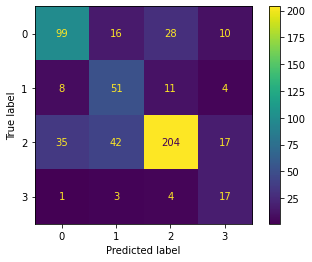

<IPython.core.display.Javascript object>

In [120]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(pipe_logreg, X, y)
plt.show()

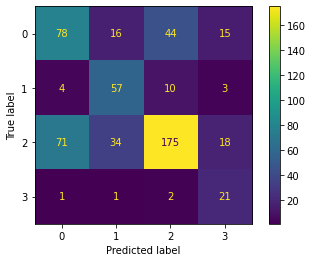

<IPython.core.display.Javascript object>

In [121]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(pipe_rf, X, y)
plt.show()

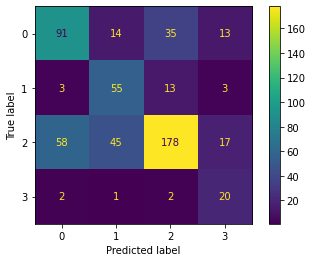

<IPython.core.display.Javascript object>

In [122]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(model, X, y)
plt.show()

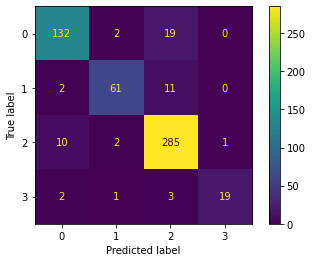

<IPython.core.display.Javascript object>

In [123]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(pipe_knn, X, y)
plt.show()

In [124]:
features = X_train.columns
coeff_df = pd.DataFrame(pipe_logreg[1].coef_[0], columns=["Coefficient"])
coeff_df["features"] = features

coeff_df.sort_values(by="Coefficient")

,Coefficient,features
253,-0.075168,Вид документа_Входящий
125,-0.071308,Табельный номер руководителя_ОРГ1-00566
248,-0.059584,Табельный номер руководителя_ОРГ2-09100
81,-0.055476,num_collegues
147,-0.050458,Табельный номер руководителя_ОРГ1-00772
...,...,...
264,0.079255,Вид документа_Файл
103,0.080617,Табельный номер руководителя_ОРГ1-00092
121,0.081429,Табельный номер руководителя_ОРГ1-00483
85,0.084190,Вид образования_Высшее образование - специалит...


<IPython.core.display.Javascript object>

In [125]:
features = X_train.columns
coeff_df = pd.DataFrame(pipe_logreg[1].coef_[1], columns=["Coefficient"])
coeff_df["features"] = features

coeff_df.sort_values(by="Coefficient")

,Coefficient,features
263,-0.095235,Вид документа_Служебная записка
267,-0.075141,Состояние задания_Завершено
85,-0.066426,Вид образования_Высшее образование - специалит...
92,-0.064506,Вид образования_Повышение квалификации
264,-0.058898,Вид документа_Файл
...,...,...
213,0.058148,Табельный номер руководителя_ОРГ1-02703
253,0.079513,Вид документа_Входящий
97,0.080937,Вид образования_Среднее профессиональное образ...
81,0.133585,num_collegues


<IPython.core.display.Javascript object>

In [126]:
features = X_train.columns
coeff_df = pd.DataFrame(pipe_logreg[1].coef_[2], columns=["Coefficient"])
coeff_df["features"] = features

coeff_df.sort_values(by="Coefficient")

,Coefficient,features
184,-0.063366,Табельный номер руководителя_ОРГ1-01649
147,-0.055802,Табельный номер руководителя_ОРГ1-00772
81,-0.052264,num_collegues
125,-0.051959,Табельный номер руководителя_ОРГ1-00566
248,-0.050171,Табельный номер руководителя_ОРГ2-09100
...,...,...
270,0.045116,Состояние задания_Отложено
251,0.046275,Вид документа_Внутренний документ
89,0.046446,Вид образования_Неполное высшее образование
145,0.051054,Табельный номер руководителя_ОРГ1-00747


<IPython.core.display.Javascript object>

In [127]:
features = X_train.columns
coeff_df = pd.DataFrame(pipe_logreg[1].coef_[3], columns=["Coefficient"])
coeff_df["features"] = features

coeff_df.sort_values(by="Coefficient")

,Coefficient,features
97,-0.088475,Вид образования_Среднее профессиональное образ...
79,-0.086485,Det_late_time__minimum
29,-0.077269,Det_monitorTime__minimum
84,-0.074992,Вид образования_Высшее образование - бакалавриат
282,-0.049398,"Просрочено, дней__standard_deviation"
...,...,...
181,0.101903,Табельный номер руководителя_ОРГ1-01461
207,0.128360,Табельный номер руководителя_ОРГ1-02511
184,0.144908,Табельный номер руководителя_ОРГ1-01649
147,0.148554,Табельный номер руководителя_ОРГ1-00772


<IPython.core.display.Javascript object>

In [128]:
fi_dict.head(30)

,Feature Id,Importances
0,Состояние задания_Завершено,10.624755
1,Табельный номер руководителя_ОРГ2-09100,8.353899
2,num_collegues,7.306766
3,Det_maxLogOff__maximum,5.978016
4,Det_fact_start__mean,5.326640
5,Det_maxLogOff__root_mean_square,5.304500
6,Det_maxLogOff__standard_deviation,5.154712
7,Det_norm_start__maximum,5.041401
8,Вид документа_Входящий,4.581427
9,Det_activeTime__minimum,4.076441


<IPython.core.display.Javascript object>